<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/Predict_DualLTSM_Technical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-tqdm

TensorFlow 1.x selected.


In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn import preprocessing
import numpy as np
import datetime as dt
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

import seaborn as sns
from tqdm.notebook import tqdm
from keras_tqdm import TQDMNotebookCallback

np.random.seed(4)
sns.set()
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale=1.2)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Globals

In [3]:
history_points = 60
data_folder = "drive/My Drive/FintechData/" + str(dt.date.today())

# Function

In [4]:
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def create_dataset(ticker):
    HIGH = 0
    LOW = 1
    OPEN = 2
    CLOSE = 3

    end_date = dt.date.today()
    start_date = end_date - dt.timedelta(365 * 20)
    data = pdr.get_data_yahoo(ticker, start_date, end_date)
    data.reset_index(inplace=True)
    data.rename(columns={'Open': 'open',
                         'High': 'high',
                         'Low': 'low',
                         'Close': 'close',
                         'Volume': 'volume'},
                inplace=True)
                
    dates = data.Date.values
    prices = data[['open', 'high', 'low', 'close']]
    volume = data['volume']
    data.drop(columns=['Date', 'Adj Close'], inplace=True)
    data = data.values

    price_min = np.min(prices.min().values)
    price_max = np.max(prices.max().values)
    prices = (prices - price_min) / (price_max - price_min)
    prices_normalised = prices.values.reshape(-1, 4)

    volume_normaliser = preprocessing.MinMaxScaler()
    volume_normalised = volume_normaliser.fit_transform(volume.values.reshape(len(data), -1))

    #data_normalised = np.concatenate((prices_normalised, volume_normalised), axis=1)

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    ohlcv_last = np.array([data_normalised[-history_points:].copy()])
    next_day_values_normalised = np.array([data_normalised[:, [OPEN, CLOSE]][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    #next_day_values_normalised = np.expand_dims(next_day_values_normalised, -1)

    next_day_values = np.array([data[:, [OPEN, CLOSE]][i + history_points].copy() for i in range(len(data) - history_points)])
    #next_day_values = np.expand_dims(next_day_values, -1)

    #print(next_day_values_normalised.shape)
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_values)


    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, CLOSE])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][CLOSE]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in np.concatenate((ohlcv_histories_normalised, ohlcv_last)):
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, CLOSE])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        #technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)
    technical_indicators_last = technical_indicators_normalised[-1:].reshape(1, 1)
    technical_indicators_normalised = technical_indicators_normalised[:-1]

    dates = dates[-ohlcv_histories_normalised.shape[0]:]
    assert ohlcv_histories_normalised.shape[0] == next_day_values_normalised.shape[0] 
    assert ohlcv_histories_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return (ohlcv_histories_normalised,
            ohlcv_last,
            technical_indicators_normalised,
            technical_indicators_last,
            next_day_values_normalised,
            next_day_values,
            price_min,
            price_max,
            y_normaliser,
            dates)
    
def build_test_train_data(ohlcv_histories, 
                          technical_indicators, 
                          next_day_values,
                          unscaled_y,
                          dates):
    test_split = 0.9
    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_train = ohlcv_histories[:n]
    tech_ind_train = technical_indicators[:n]
    y_train = next_day_values[:n]

    ohlcv_test = ohlcv_histories[n:]
    tech_ind_test = technical_indicators[n:]
    y_test = next_day_values[n:]
    unscaled_y_test = unscaled_y[n:]
    dates_test = dates[n:]

    return (ohlcv_train, 
            tech_ind_train, 
            y_train,
            ohlcv_test,
            tech_ind_test,
            y_test,
            unscaled_y_test,
            dates_test)
    
def build_train_model(ticker,
                      ohlcv_train,
                      tech_ind_train,
                      y_train,
                      history_points, 
                      technical_indicators,
                      force_train=False):
    # model architecture

    maybe_make_dir(data_folder)
    model_name = data_folder + "/technical_model_" + ticker + ".h5"

    if (os.path.exists(model_name) and not force_train):
        return keras.models.load_model(model_name)
    
    # define two sets of inputs
    lstm_input = Input(shape=(history_points, 5), name='lstm_input')
    dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

    # the first branch operates on the first input
    x = CuDNNLSTM(200, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    lstm_branch = Model(inputs=lstm_input, outputs=x)

    # the second branch opreates on the second input
    y = Dense(50, name='tech_dense_0')(dense_input)
    y = Activation("relu", name='tech_relu_0')(y)
    y = Dropout(0.2, name='tech_dropout_0')(y)
    technical_indicators_branch = Model(inputs=dense_input, outputs=y)

    # combine the output of the two branches
    combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

    z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
    z = Dense(2, activation="linear", name='dense_out')(z)

    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.1, verbose=0, callbacks=[TQDMNotebookCallback()])
    print ("Save Model at:" + model_name)
    model.save(model_name)
    return model


def predict_test_data(model,
                      ohlcv_test,
                      tech_ind_test,
                      ohlcv_last,
                      tech_ind_last,
                      unscaled_y_test,
                      price_min,
                      price_max,
                      y_normaliser):
    y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
    #y_test_predicted = y_test_predicted * (price_max - price_min) + price_min
    assert unscaled_y_test.shape == y_test_predicted.shape
    real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
    scaled_mse = real_mse / (np.max(unscaled_y_test[:,0]) - np.min(unscaled_y_test[:,0])) * 100
    print("MSE: Scaled:{0:6.3f}".format(scaled_mse))
    scaled_mse = real_mse / (np.max(unscaled_y_test[:,1]) - np.min(unscaled_y_test[:,1])) * 100
    print("MSE: Scaled:{0:6.3f}".format(scaled_mse))
    y_last_predicted = model.predict([ohlcv_last, tech_ind_last])
    y_last_predicted = y_normaliser.inverse_transform(y_last_predicted)
    #y_last_predicted = y_last_predicted * (price_max - price_min) + price_min

    return y_test_predicted, y_last_predicted

def calculate_portfolio(portfolio_df):
    LONG = 1 
    SHORT = -1
    HOLD = 0

    position = HOLD
    start_trade_price = 0
    yday_close_price = 0
    open_prices = portfolio_df['real_open'].values
    close_prices = portfolio_df['real_close'].values
    signals = portfolio_df['signal'].values
    profit = 0

    for open_price, close_price, signal in zip(open_prices, close_prices, signals):
        if signal != position:
            if position != HOLD:
                profit += (position * ((yday_close_price - start_trade_price) / start_trade_price))
            start_trade_price = open_price
        yday_close_price = close_price
        position = signal

    print("Profit:{0:6.3f}".format(profit))

def calculate_accuracy(unscaled_y_test,
                       y_test_predicted, 
                       dates_test,
                       time_span,
                       time_step=5, 
                       start=0, 
                       end=-1):
    raw_data = np.concatenate((unscaled_y_test[:,0].reshape(len(unscaled_y_test), -1),
                               unscaled_y_test[:,1].reshape(len(unscaled_y_test), -1), 
                               y_test_predicted[:,0].reshape(len(unscaled_y_test), -1),
                               y_test_predicted[:,1].reshape(len(unscaled_y_test), -1)),
                              axis=1)
    
    result = pd.DataFrame(raw_data,
                          columns=['real_open', 'real_close', 'pred_open', 'pred_close'], 
                          index=dates_test)

    #result['open_chg'] = result.pred_open - result.pred_open.shift(1)
    #result['close_chg'] = result.pred_close - result.pred_close.shift(1)
    result['open_diff'] = result.pred_open - result.real_open
    result['open_diff'] = result.open_diff.rolling(window=history_points).mean()
    result['open_adj'] = result.pred_open - result.open_diff
    result['close_diff'] = result.pred_close - result.real_close
    result['close_diff'] = result.close_diff.rolling(window=history_points).mean()
    result['close_adj'] = result.pred_close - result.close_diff
    result['pred_chg'] = (result['close_adj'].pct_change() - result['open_adj'].pct_change())
    #result['pred_chg'] = result.pred_chg.apply(lambda x: 0 if np.abs(x) < 0.03 else x)
    result.dropna(inplace=True)
    #result['pred_chg'] = result.open_chg
    result['real_chg'] = (result.real_close - result.real_open) / result.real_open
    portfolio = result.copy()
    result = result[result.pred_chg != 0]
    #result['corr'] = result.apply(calc_corr, axis=1)
    result['corr'] = np.sign(1 + np.sign(result.real_chg * result.pred_chg))


    portfolio['signal'] = portfolio.pred_chg.apply(lambda x: -1 if x <= 0 else 1)
    portfolio['long_trade'] = np.sign(1 + portfolio.signal) * portfolio.real_chg
    portfolio['short_trade'] = np.sign(portfolio.signal - 1) * portfolio.real_chg

    portfolio['base_profit'] = portfolio.real_chg.cumsum()*100
    portfolio['long_profit'] = portfolio.long_trade.cumsum()*100
    portfolio['short_profit'] = portfolio.short_trade.cumsum()*100
    portfolio['all_profit'] = portfolio.long_profit + portfolio.short_profit

    calculate_portfolio(portfolio)

    portfolio_over_times_dfs = []
    for _time_span in [63, 126, 252]:
        long_profits = []
        all_profits = []
        short_profits = []
        base_profits = []
        for i in tqdm(range(0, len(portfolio) - _time_span, time_step)):
            porfolio_span = portfolio[i:i+time_span][['real_open', 'real_close', 'real_chg', 'pred_chg', 'long_trade', 'short_trade']]
            porfolio_span['base_profit'] = porfolio_span.real_chg.cumsum() * 100
            porfolio_span['long_profit'] = porfolio_span.long_trade.cumsum() * 100
            porfolio_span['short_profit'] = porfolio_span.short_trade.cumsum() * 100
            porfolio_span['all_profit'] = porfolio_span.long_profit + porfolio_span.short_profit
            prices = porfolio_span[['real_open', 'real_close']].values
            first_open = prices[0][0]
            last_close = prices[-1][1]
            base_profit = (last_close - first_open) * 100 / first_open
            last_row = porfolio_span.tail(1).values
            base_profits.append(base_profit)
            long_profits.append(last_row[0][-3])
            short_profits.append(last_row[0][-2])
            all_profits.append(last_row[0][-1])

        portfolio_over_times = pd.DataFrame({'Base Profit':base_profits, 
                                            'Long Profit':long_profits, 
                                            'Short Profit':short_profits,
                                            'All Profit':all_profits},
                                            index=dates_test[-len(base_profits):])
        portfolio_over_times_dfs.append(portfolio_over_times)
    return result, portfolio, portfolio_over_times_dfs



# Build, Train Model
# Calculate Result

In [12]:
ticker = "SBUX" #@param ["^GSPC", "^IXIC", "^DJI", "^VIX", "INTC", "SBUX", "NFLX", "MSFT", "QCOM", "GE", "GOOGL", "NVDA", "CSCO"]
time_span = 3 #@param {type:"slider", min:1, max:24, step:1}
force_train = False #@param {type:"boolean"}
time_span *= 21


In [9]:
ohlcv_histories, ohlcv_last, technical_indicators, tech_ind_last, next_day_values, unscaled_y, price_min, price_max, y_normaliser, dates = \
create_dataset(ticker)

# Build train and test data for both ohlcv and technical indicator
ohlcv_train, tech_ind_train, y_train, ohlcv_test, tech_ind_test, y_test, unscaled_y_test, dates_test = \
build_test_train_data(ohlcv_histories=ohlcv_histories, 
                    technical_indicators=technical_indicators, 
                    next_day_values=next_day_values,
                    unscaled_y=unscaled_y,
                    dates=dates)

# Build Model and train with train data
model = build_train_model(ticker=ticker,
                        ohlcv_train=ohlcv_train,
                        tech_ind_train=tech_ind_train,
                        y_train=y_train,
                        history_points=history_points, 
                        technical_indicators=technical_indicators,
                        force_train=force_train)

# Build a predict price for test data
y_test_predicted, y_last_predicted = predict_test_data(model=model,
                                                    ohlcv_test=ohlcv_test,
                                                    tech_ind_test=tech_ind_test,
                                                    ohlcv_last=ohlcv_last,
                                                    tech_ind_last=tech_ind_last,
                                                    unscaled_y_test=unscaled_y_test,
                                                    price_min=price_min,
                                                    price_max=price_max,
                                                    y_normaliser=y_normaliser)

# Calculate and plot accuracy metrics
result, portfolio, portfolio_over_time_dfs = calculate_accuracy(unscaled_y_test=unscaled_y_test,
                                                                y_test_predicted=y_test_predicted,
                                                                dates_test=dates_test,
                                                                time_span=time_span,
                                                                time_step=10)
end_date = dt.date.today()
start_date = end_date - dt.timedelta(365 * 2)
orig_data = pdr.get_data_yahoo(ticker, start_date, end_date)
result_folder = data_folder + "/" + ticker
maybe_make_dir(result_folder)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




Save Model at:drive/My Drive/FintechData/2020-06-29/technical_model_CSCO.h5
MSE: Scaled:238.801
MSE: Scaled:239.282
Profit: 1.215


# Reuslt

## Prediction

In [13]:
#pd.set_option('display.max_rows', 100)
#display(portfolio.join(orig_data[['Open', 'Close']]))
portfolio.to_csv(result_folder + "/portfolio.csv")
portfolio_over_time_dfs[0].to_csv(result_folder + "/portfolio_dist_0.csv")
portfolio_over_time_dfs[1].to_csv(result_folder + "/portfolio_dist_1.csv")
portfolio_over_time_dfs[2].to_csv(result_folder + "/portfolio_dist_2.csv")

In [14]:
print("Accuracy:{0:6.2f}".format(result['corr'].sum() * 100/len(result)))
last_row = portfolio.tail(1).values
prices = portfolio[['real_open', 'real_close']].values
first_open = prices[0][0]
last_close = prices[-1][1]
base_profit = (last_close - first_open) * 100 / first_open
print("Profit:\n\tBase:{0:6.3f}\n\tLong:{1:6.3f}\n\tShort:{2:6.3f}\n\tAll:{3:6.3f}".
        format(base_profit, last_row[0][-3], last_row[0][-2], last_row[0][-1]))



Accuracy: 54.46
Profit:
	Base:-5.005
	Long:36.745
	Short:49.651
	All:86.396


## Tomorrow Prediction

In [13]:
last_row = result.tail(1)
open_diff = last_row['open_diff'].values[0]
close_diff = last_row['close_diff'].values[0]
open_adj_pred = y_last_predicted[0][0] - open_diff 
close_adj_pred = y_last_predicted[0][1] - close_diff 
print(open_diff, close_diff, y_last_predicted, open_adj_pred, close_adj_pred)
if close_adj_pred > open_adj_pred:
    print("Tomorrow Action: LONG")
else:
    print("Tomorrow Action: SHORT")
prediction_file = open(result_folder + "/prediction.txt", 'w')
print('{0:6.3f}\n{1:6.3f}'.format(open_adj_pred, close_adj_pred), file = prediction_file)
prediction_file.close()


-30.40653279622396 -31.97182820638021 [[1374.139  1372.1798]] 1404.5455708821614 1404.1516377766927
Tomorrow Action: SHORT


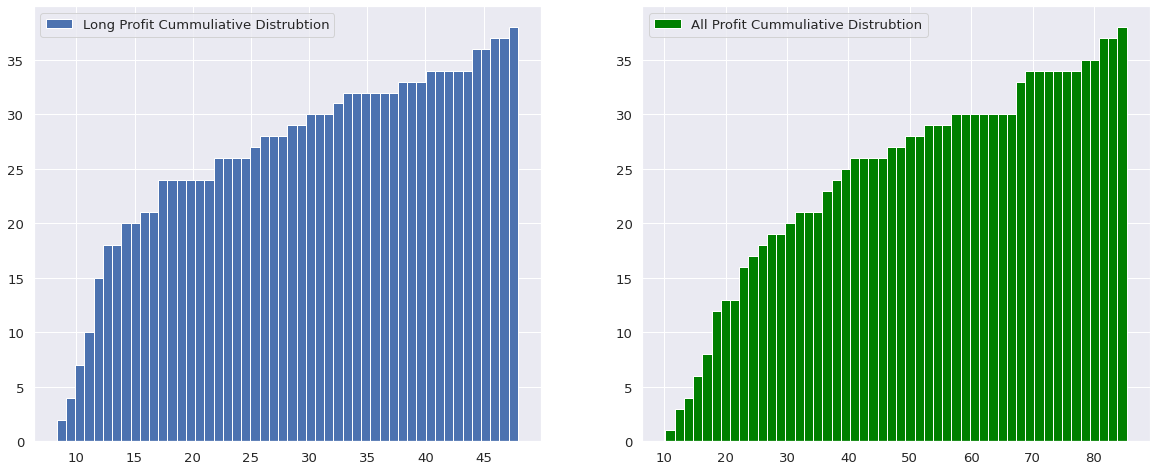

In [16]:
fig, axs = plt.subplots(1,2)
axs[0].hist(portfolio_over_time['Long Profit'], bins=50, cumulative=True, label="Long Profit Cummuliative Distrubtion")
axs[0].legend()

axs[1].hist(portfolio_over_time['All Profit'], bins=50, cumulative=True, label="All Profit Cummuliative Distrubtion", color='green')
axs[1].legend()
plt.show()

In [17]:
display(portfolio_over_time[['Base Profit', 'Long Profit', 'All Profit']].describe())

,Base Profit,Long Profit,All Profit
count,38.000000,38.000000,38.000000
mean,4.239687,20.444273,37.072276
std,10.632472,12.228567,23.132025
min,-16.929844,8.317003,10.207194
25%,-0.108327,11.428929,18.045629
50%,3.645795,14.196898,28.899455
75%,9.138541,27.983448,52.570767
max,39.748068,47.951405,85.327581


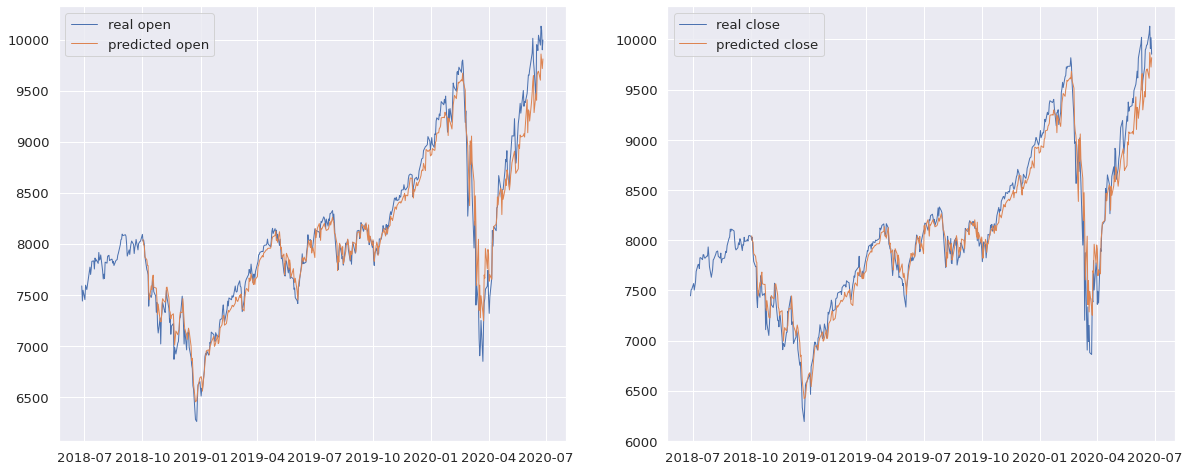

In [11]:
fig, axs = plt.subplots(1,2)

#axs[0].plot(orig_data.Close, label='real close', linewidth=1)
#axs[0].plot(result.pred_close, label='predicted close', linewidth=1)
axs[0].plot(orig_data.Open, label='real open', linewidth=1)
axs[0].plot(result.open_adj, label='predicted open', linewidth=1)
axs[0].legend()
#axs[0].title("Price Comparision")
#plt.show()


axs[1].plot(orig_data.Close, label='real close', linewidth=1)
axs[1].plot(result.close_adj, label='predicted close', linewidth=1)
axs[1].legend()
#axs[1].title("Daily Return Comparision")
plt.show()

## Trade History

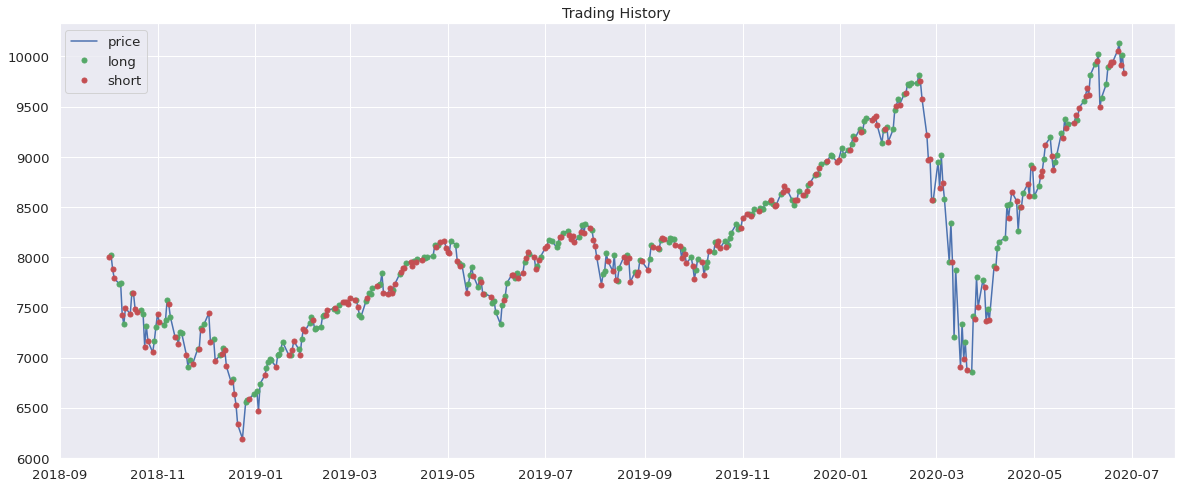

In [12]:
fig, axs = plt.subplots()

axs.plot(portfolio.real_close, label='price')
# Plot the buy signals
axs.plot(portfolio.loc[portfolio.pred_chg > 0].index, 
               portfolio.real_close[portfolio.pred_chg > 0],
               'o', markersize=5, color='g', label="long")
# Plot the buy signals
axs.plot(portfolio.loc[portfolio.pred_chg < 0].index, 
               portfolio.real_close[portfolio.pred_chg < 0],
               'o', markersize=5, color='r', label="short")
plt.title("Trading History")
axs.legend()
plt.show()

## Profits and Trading

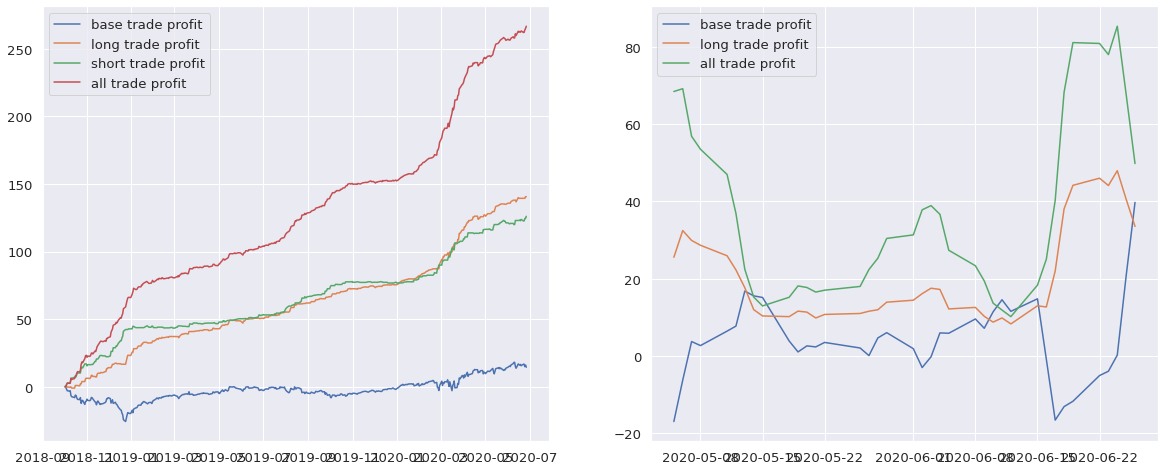

In [13]:
fig, axs = plt.subplots(1,2)
axs[0].plot(portfolio['base_profit'], label='base trade profit')
axs[0].plot(portfolio['long_profit'], label='long trade profit')
axs[0].plot(portfolio['short_profit'], label='short trade profit')
axs[0].plot(portfolio['all_profit'], label='all trade profit')
axs[0].legend()

axs[1].plot(portfolio_over_time['Base Profit'], label='base trade profit')
axs[1].plot(portfolio_over_time['Long Profit'], label='long trade profit')
#axs[1].plot(portfolio_over_time['Short Profit'], label='short trade profit')
axs[1].plot(portfolio_over_time['All Profit'], label='all trade profit')
axs[1].legend()
plt.show()


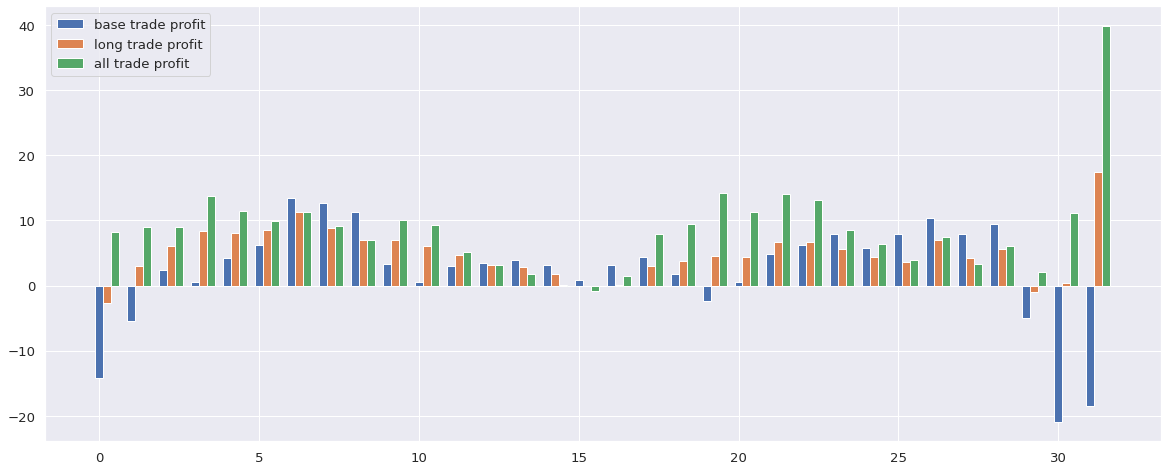

In [16]:
ind = np.arange(len(portfolio_over_time_dfs[1]))
plt.bar(x=ind, height=portfolio_over_time_dfs[1]['Base Profit'], label='base trade profit', width=0.25)
plt.bar(x=ind+0.25, height=portfolio_over_time_dfs[1]['Long Profit'], label='long trade profit', width=0.25)
#axs[1].plot(portfolio_over_time['Short Profit'], label='short trade profit')
plt.bar(x=ind+0.5, height=portfolio_over_time_dfs[1]['All Profit'], label='all trade profit', width=0.25)
#axs[1].xaxis_date()

plt.legend()
plt.show()


## Profit Statistics

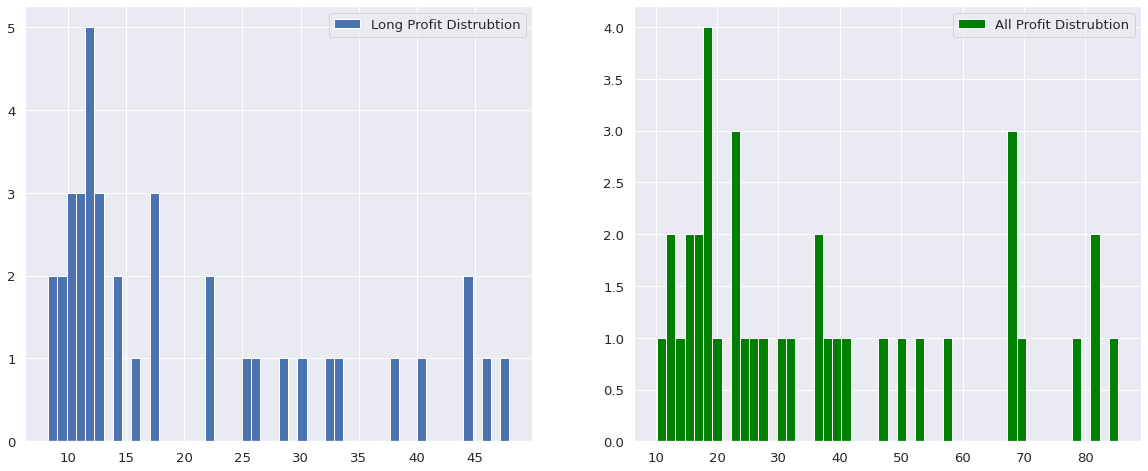

In [15]:
fig, axs = plt.subplots(1,2)
axs[0].hist(portfolio_over_time['Long Profit'], bins=50, label="Long Profit Distrubtion")
axs[0].legend()

axs[1].hist(portfolio_over_time['All Profit'], bins=50, label="All Profit Distrubtion", color='green')
axs[1].legend()
plt.show()